In [1]:
import logging
import os
import re
from typing import Optional, List
from pathlib import Path

import scipy
import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import wandb
from skimage.draw import polygon2mask
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, BatchSampler
from torchvision.transforms import ColorJitter, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomAdjustSharpness
from timm import create_model
from einops import rearrange, reduce
from skimage.color import label2rgb
from skimage.measure import regionprops_table

In [2]:
ds_dir = '../data/pytorch_datasets/pdac_v4'

In [3]:
genes = ['EPCAM', 'KRT18', 'MKI67', 'IL7R', 'MS4A1', 'BGN', 'PECAM1']

In [4]:
train_adata = sc.read_h5ad('../data/pdac/HT270P1-S1H1U1/adata.h5ad')
train_adata.X = train_adata.layers['counts'] # using raw counts
train_adata = train_adata[:, [True if v or g in genes else False
                              for v, g in zip(train_adata.var['highly_variable'], train_adata.var.index)]]
train_adata

View of AnnData object with n_obs × n_vars = 3940 × 2002
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
val_adata = sc.read_h5ad('../data/pdac/HT264P1-S1H2U1/adata.h5ad')
val_adata.X = val_adata.layers['counts'] # using raw counts
val_adata = val_adata[:, train_adata.var.index]

val_adata

View of AnnData object with n_obs × n_vars = 3234 × 2002
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
import math
def get_hex_stamp(radius=100):
    r, c = 0, 0
    sl = (2 * radius) * math.tan(math.pi / 6)

    # calculate coordinates of the hexagon points
    p = sl * 0.5
    b = sl * math.cos(math.radians(30))
    w = b * 2
    h = 2 * sl

    rs = [r, r, r + b, r + w, r + w, r + b, r]
    cs = [c + p, c + (3 * p), c + h, c + (3 * p), c + p, c, c + p]
    pts = np.asarray([(r, c) for r, c in zip(rs, cs)])
    
    max_r, max_c = pts.max(axis=0)
    min_r, min_c = pts.min(axis=0)
    pts[:, 0] -= min_r
    pts[:, 1] -= min_c
    pts = pts.astype(np.int32)
    
    mask = polygon2mask((pts.max(axis=0)[0], pts.max(axis=0)[1]), pts)

    return mask

In [7]:
def centroid_distance(adata, n=6, radius=300, key='spatial_8X_trimmed'):
    X = adata.obsm[key]
    nbrs = NearestNeighbors(algorithm='ball_tree').fit(X)
    
#     g = nbrs.radius_neighbors_graph(X, radius=radius, )
    g = nbrs.kneighbors_graph(X, n_neighbors=6)
    rows, cols, _ = scipy.sparse.find(g)
    
    dists = []
    for r, c in zip(rows, cols):
        dist = scipy.spatial.distance.euclidean(X[r], X[c])
        if dist != 0:
            dists.append(int(dist))
    dists = np.asarray(dists)
    vals, counts = np.unique(dists, return_counts=True)
    return vals[np.argmax(counts)]

In [8]:
def convert_spot_masks(adata, mask=None, key='8X_trimmed', mode='hex'):
    radius = centroid_distance(adata, n=6, key=f'spatial_{key}')
    radius = int(radius * .55)
    hexagon = get_hex_stamp(radius=radius)
    
    if mask is None:
        mask = adata.uns['rescaled_spot_masks'][key]

    props = regionprops_table(mask, properties=('label', 'centroid'))
    
    m = np.zeros_like(mask)
    
    for label, cent1, cent2 in zip(props['label'], props['centroid-0'], props['centroid-1']):
        tile = hexagon.copy()
        if tile.shape[0] % 2 != 0:
            tile = np.concatenate((tile, np.zeros((1, tile.shape[1]))), axis=0)
        if tile.shape[1] % 2 != 0:
            tile = np.concatenate((tile, np.zeros((tile.shape[0], 1))), axis=1)
        # check for edges
        r_offset = tile.shape[0] // 2 
        c_offset = tile.shape[1] // 2
        
        cent1, cent2 = int(cent1), int(cent2)
        
        
        
        if cent1 - r_offset < 0:
            r1 = 0
            tile = tile[:tile.shape[0] - abs(cent1 - r_offset)]
        else:
            r1 = cent1 - r_offset
            
        if cent2 - c_offset < 0:
            c1 = 0
            tile = tile[:, :tile.shape[1] - abs(cent2 - c_offset)]
        else:
            c1 = cent2 - c_offset
        
        if cent1 + r_offset > mask.shape[0]:
            tile = tile[:tile.shape[0] - (cent1 + r_offset - mask.shape[0])]
        
        if cent2 + c_offset > mask.shape[1]:
            tile = tile[:, :tile.shape[1] - (cent2 + c_offset - mask.shape[1])]

        m[r1:r1 + tile.shape[0], c1:c1 + tile.shape[1]][tile>0] = label
    return m
    

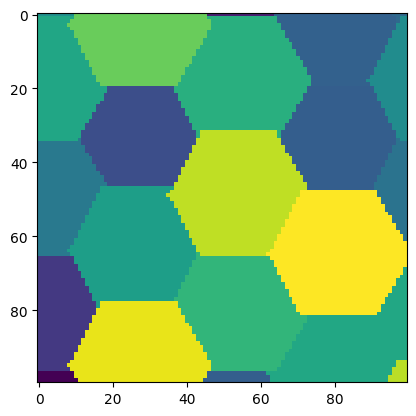

In [9]:
mask = convert_spot_masks(train_adata, key='8X_trimmed', mode='hex')
plt.imshow(mask[500:600, 500:600])

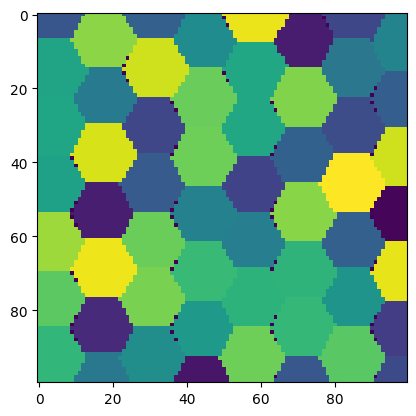

In [10]:
mask = convert_spot_masks(train_adata, key='16X_trimmed', mode='hex')
plt.imshow(mask[500:600, 500:600])

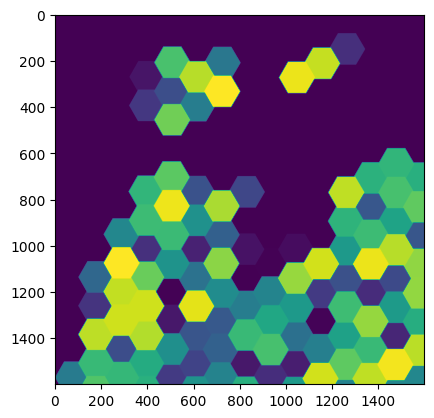

In [11]:
mask = convert_spot_masks(train_adata, key='2X_trimmed', mode='hex')
plt.imshow(mask[:1600, :1600])

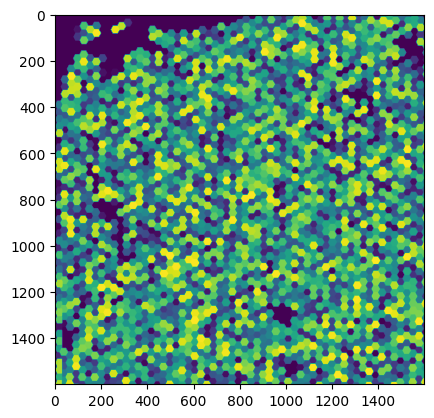

In [12]:
mask = convert_spot_masks(train_adata, key='8X_trimmed', mode='hex')
plt.imshow(mask[:1600, :1600])

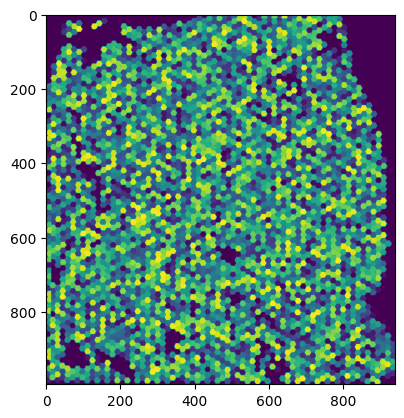

In [13]:
mask = convert_spot_masks(train_adata, key='16X_trimmed', mode='hex')
plt.imshow(mask)

In [14]:
class HETransform(object):
    def __init__(self, p=.8, brightness=.1, contrast=.1, saturation=.1, hue=.1, sharpness=.3, normalize=True):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.sharpness = sharpness
        
        if normalize:
            self.normalize = Normalize((0.771, 0.651, 0.752), (0.229, 0.288, 0.224)) # from HT397B1-H2 ffpe H&E image
        else:
            self.normalize = nn.Identity()
 
        self.p = p
    
    def apply_color_transforms(self, x, brightness, contrast, saturation, hue, sharpness):
        x = TF.adjust_brightness(x, brightness)
        x = TF.adjust_contrast(x, contrast)
        x = TF.adjust_saturation(x, saturation)
        x = TF.adjust_hue(x, hue)
        x = TF.adjust_sharpness(x, sharpness)
        return x
        
    def __call__(self, he, mask):
        """
        """
        if isinstance(he, torch.Tensor):
            hes = [he]
            masks = [mask]
            return_type = 'image'
        elif isinstance(he, dict):
            keys = list(he.keys())
            hes = [he[k] for k in keys]
            masks = [mask[k] for k in keys]
            return_type = 'dict'
        else:
            return_type = 'list'
                                
        # we apply transforms with probability p
        if torch.rand(size=(1,)) < self.p:
            brightness, contrast, saturation, hue, sharpness = (
                np.random.uniform(max(0, 1 - self.brightness), 1 + self.brightness, size=1)[0],
                np.random.uniform(max(0, 1 - self.contrast), 1 + self.contrast, size=1)[0],
                np.random.uniform(max(0, 1 - self.saturation), 1 + self.saturation, size=1)[0],
                np.random.uniform(-self.hue, self.hue, size=1)[0],
                np.random.uniform(max(0, 1 - self.sharpness), 1 + self.sharpness, size=1)[0],
            )
            # apply color jitter and sharpness
            hes = [self.apply_color_transforms(x, brightness, contrast, saturation, hue, sharpness)
                   for x in hes]
            
            # vertical and horizontal flips happen with p=.5
            do_hflip, do_vflip = torch.rand(size=(2,)) < .5 
            if do_hflip:
                hes = [TF.hflip(x) for x in hes]
                masks = [TF.hflip(x) for x in masks]
            if do_vflip:
                hes = [TF.vflip(x) for x in hes]
                masks = [TF.vflip(x) for x in masks]
        
        # normalize he
        hes = [self.normalize(x) for x in hes]
                    
        if return_type == 'image':
            return hes[0], masks[0]
        elif return_type == 'dict':
            return {k:v for k, v in zip(keys, hes)}, {k:v for k, v in zip(keys, masks)}
        return hes, masks

In [15]:
def convert_rgb(img):
    if img.shape[-1] == 3:
        img = rearrange(img, 'h w c -> c h w')
        
    if not isinstance(img, torch.Tensor):
        img = torch.tensor(img)
        
    if torch.max(img)>1.1:
        img = TF.convert_image_dtype(img, dtype=torch.float32)
            
    return img


def generate_voxel_masks(labeled_mask, padded_spot_idxs, n_voxels):
    masks = torch.zeros((padded_spot_idxs.shape[0], labeled_mask.shape[0], labeled_mask.shape[1]))
    for i, l in enumerate(padded_spot_idxs[:n_voxels]):
        m = labeled_mask.clone().detach()
        m[m!=l] = 0.
        m[m==l] = 1.
        masks[i] = m
    return masks


def generate_padded_exp(adata, spot_idxs, max_spots, masks, pixels_per_voxel, use_raw=False):
    if use_raw:
        x = adata.raw.X[spot_idxs]
    else:
        x = adata.X[spot_idxs]

    if 'sparse' in str(type(x)).lower():
        x = x.toarray()

    padded_exp = torch.zeros((max_spots, x.shape[1]))
    padded_exp[:x.shape[0]] = torch.tensor(x)

    padded_exp *= (masks.sum(dim=(1,2)).unsqueeze(dim=-1) + 1.) / pixels_per_voxel
    padded_exp = torch.round(padded_exp)
    
    return padded_exp


class STDataset(Dataset):
    """ST Dataset"""
    def __init__(self, adata, he_dict, mask_dict, coordinate_key,
                 tile_sizes=512, use_raw=False, he_transform=None,
                 border=512, max_jitter=0., sample_multiplier=1):
        """
        adata: AnnData object
            - .X must be unnormalized counts
            - must have column in .obs['spot_index'] that specified the spot index in the scaled mask dict
        scaled_he_dict: dict
            - values are rgb H&E images, keys are '[0-9]+X', where the integer in front of X is the scale factor of the H&E image.
        scaled_mask_dict: dict
            - values are labeled images where 0 is background and all other pixels coorespond to index stored in .obs['spot_index'].
        """
        super().__init__()
        # make sure we are ordered by spot index
        self.spot_ids, _ = zip(*sorted([(sid, sidx) for sid, sidx in zip(adata.obs.index, adata.obs['spot_index'])],
                                    key=lambda x: x[1]))
        self.spot_ids = np.asarray(self.spot_ids)
        self.adata = adata[self.spot_ids]
        self.he_dict = {k:convert_rgb(v) for k, v in he_dict.items()}
        self.mask_dict = {k:torch.tensor(v).to(torch.int32) if not isinstance(v, torch.Tensor) else v
                                 for k, v in mask_dict.items()}
        self.scales = sorted([int(re.sub(r'^([0-9]+)X$', r'\1', k)) for k in self.he_dict.keys()])
        
        if isinstance(tile_sizes, int):
            self.tile_sizes = [tile_sizes] * len(self.scales)
        else:
            self.tile_sizes = tile_sizes # defines the size of crops to be taken from each h&e resolution
        
        _, n_row, n_col = self.he_dict[str(self.scales[0]) + 'X'].shape
        self.offset = int(self.tile_sizes[0] // 2 + 1)
        self.border = border
  
        self.pixel_coords = np.asarray(
            [[int(r + np.random.uniform(-max_jitter, max_jitter)),
              int(c + np.random.uniform(-max_jitter, max_jitter))]
             for c, r in self.adata.obsm[coordinate_key]])
        if sample_multiplier > 1:
            for i in range(sample_multiplier - 1):
                self.pixel_coords = np.concatenate(
                    (self.pixel_coords,
                     np.asarray(
                        [[int(r + np.random.uniform(-max_jitter, max_jitter)),
                          int(c + np.random.uniform(-max_jitter, max_jitter))]
                         for c, r in self.adata.obsm[coordinate_key]])), axis=0)
        
        self.he_transform = he_transform
        
        
        # expression related
        self.use_raw = use_raw
        
        idxs = np.random.choice(np.arange(self.pixel_coords.shape[0]), size=1000)
        key = str(self.scales[0]) + 'X'
        max_spots = 0
        self.pixels_per_voxel = 0
        for i in idxs:
            mask = self.mask_dict[key]
            r, c = self.pixel_coords[i]
            r, c = r + self.border, c + self.border # adjust for reflection padding
            r, c = r - self.offset, c - self.offset # adjust from center to top left
            m = TF.crop(mask, top=r, left=c, height=self.tile_sizes[0], width=self.tile_sizes[0])
            max_spots = max(max_spots, len(np.unique(m)))
        self.max_spots = 2**int(np.log2(max_spots) + 1)
        
        r, c = n_row // 2, n_col // 2
        tile = self.mask_dict[key][r:r + self.tile_sizes[0] * 2, c:c + self.tile_sizes[0] * 2]
        self.pixels_per_voxel = np.max(
            regionprops_table(tile.detach().numpy(), properties=['label', 'area'])['area'])
        
    
    def get_item_dict(self, idx, apply_transform=True):
        r, c = self.pixel_coords[idx]
        initial = self.scales[0]
        scale_to_coords = {s: (
                               int((r / (s / initial)) - self.offset + self.border),
                               int((c / (s / initial)) - self.offset + self.border)
                           )
                           for i, s in enumerate(self.scales)}
        he_tile_dict, mask_tile_dict = {}, {}
        for scale, tile_size in zip(self.scales, self.tile_sizes):
            key = f'{scale}X'
            he, mask = self.he_dict[key], self.mask_dict[key]
            r, c = scale_to_coords[scale]
            he_tile_dict[key] = TF.crop(he, top=r, left=c, height=tile_size, width=tile_size)
            mask_tile_dict[key] = TF.crop(mask, top=r, left=c, height=tile_size, width=tile_size)
        if self.he_transform is not None and apply_transform:
            he_tile_dict, mask_tile_dict = self.he_transform(he_tile_dict, mask_tile_dict)
        spot_idxs = torch.unique(mask_tile_dict[str(self.scales[0]) + 'X']).numpy() - 1
        if spot_idxs[0] == 0:
            spot_idxs = spot_idxs[1:] # drop first value, which is background
        padded_spot_idxs = np.asarray([0] * self.max_spots)
        padded_spot_idxs[:spot_idxs.shape[0]] = spot_idxs + 1
        masks = generate_voxel_masks(mask_tile_dict[str(self.scales[0]) + 'X'],
                                     padded_spot_idxs, len(spot_idxs))
        padded_exp = generate_padded_exp(self.adata, spot_idxs, self.max_spots,
                                         masks, self.pixels_per_voxel, use_raw=self.use_raw)
                
        return {
            'X': padded_exp,
            'he_tiles': he_tile_dict,
            'mask_tiles': mask_tile_dict,
            'voxel_idxs': padded_spot_idxs,
            'masks': masks,
            'n_voxels': len(spot_idxs),
            'b': torch.tensor([1.]), # just make everything the same batch for now
            'voxel_idx': idx,
        }

    def __len__(self):
        return len(self.pixel_coords)

    def __getitem__(self, idx):
        return self.get_item_dict(idx)
        

In [16]:
def reflection_mosiac(x, border=256, dtype=torch.int32):
    max_r, max_c = x.shape[-2], x.shape[-1]
    if len(x.shape) == 3:
        mosaic = torch.zeros((x.shape[0], max_r + (border * 2), max_c + (border * 2))).to(dtype)
    else:
        mosaic = torch.zeros((max_r + (border * 2), max_c + (border * 2))).to(dtype)
    
    # make tiles
    top_left = TF.pad(x, padding=[border, border, 0, 0], padding_mode='reflect')
    top_right = TF.pad(x, padding=[0, border, border, 0], padding_mode='reflect')
    bottom_left = TF.pad(x, padding=[border, 0, 0, border], padding_mode='reflect')
    bottom_right = TF.pad(x, padding=[0, 0, border, border], padding_mode='reflect')
    
    if len(x.shape) == 3:
        mosaic[:, :max_r + border, :max_c + border] = top_left
        mosaic[:, :max_r + border, border:] = top_right
        mosaic[:, border:, :max_c + border] = bottom_left
        mosaic[:, border:, border:] = bottom_right
    else:
        mosaic[:max_r + border, :max_c + border] = top_left
        mosaic[:max_r + border, border:] = top_right
        mosaic[border:, :max_c + border] = bottom_left
        mosaic[border:, border:] = bottom_right
    
    return mosaic

In [17]:
def get_img_dicts(adata, keys=('2X', '8X'), border=256, mode='spot'):
    he_dict = {}
    for k, x in adata.uns['rescaled_he'].items():
        if re.findall(r'^[0-9]+X.*$', k) and 'trimmed' in k:
            scale = int(re.sub(r'^([0-9]+)X.*$', r'\1', k))
            x = torch.tensor(rearrange(x, 'h w c -> c h w')).to(torch.uint8)
            x = reflection_mosiac(x, border=border, dtype=torch.uint8)
            x = rearrange(x, 'c h w -> h w c').numpy().astype(np.uint8)
            he_dict[f'{scale}X'] = x
            
    mask_dict = {}
    for k, x in adata.uns['rescaled_spot_masks'].items():
        if re.findall(r'^[0-9]+X.*$', k) and 'trimmed' in k:
            scale = int(re.sub(r'^([0-9]+)X.*$', r'\1', k))
            x = torch.tensor(x.astype(np.int32))
            x = reflection_mosiac(x, border=border, dtype=torch.int32)
            x = x.numpy().astype(np.int32)
            mask_dict[f'{scale}X'] = x
            
    if mode == 'hex':
        mask_dict = {k:convert_spot_masks(adata, mask=v, key=f'{k}_trimmed', mode='hex')
                     for k, v in mask_dict.items()}
            
    he_dict = {k:v for k, v in he_dict.items() if k in keys}
    mask_dict = {k:v for k, v in mask_dict.items() if k in keys}
    
    return he_dict, mask_dict

In [18]:
keys = ['2X', '8X']
tile_size = 256
spot_radius = train_adata.uns['rescaled_spot_metadata'][keys[0] + '_trimmed']['spot_radius']
jitter = spot_radius * 2
border = jitter * 2
# border = spot_radius * 4

he_dict, mask_dict = get_img_dicts(train_adata, keys=keys, border=border, mode='hex')

train_he_transform = HETransform(p=.95, brightness=.1, contrast=.1, saturation=.1, hue=.1, normalize=False)
train_ds = STDataset(train_adata, he_dict, mask_dict, 'spatial_2X_trimmed',
                     tile_sizes=tile_size, he_transform=train_he_transform,
                     max_jitter=0., border=border, sample_multiplier=2)

In [19]:
he_dict, mask_dict = get_img_dicts(val_adata, keys=keys, border=border, mode='hex')
# pool = [724, 800, 397, 1011, 1022, 2011]
val_he_transform = HETransform(p=0.0, normalize=False)
val_ds = STDataset(val_adata, he_dict, mask_dict, 'spatial_2X_trimmed',
                   tile_sizes=tile_size, he_transform=val_he_transform,
                   max_jitter=0., border=border, sample_multiplier=1)

In [20]:
len(train_ds)

7880

In [37]:
def save_tensor_data(ds, directory):
    for i in range(len(ds)):
        if i % 1000 == 0 and i:
            print(i)
#             break
        d = ds[i]
        he = TF.convert_image_dtype(d['he_tiles']['2X'], dtype=torch.uint8)
        masks = d['masks'].to(torch.bool)
        voxel_idxs = torch.tensor(d['voxel_idxs'], dtype=torch.int16)
        exp = d['X'].to(torch.int32)
        torch.save({
            'he': he,
            'masks': masks,
            'voxel_idxs': voxel_idxs,
            'exp': exp
        }, os.path.join(directory, f'{i}.pt'))

In [38]:
train_dir = os.path.join(ds_dir, 'train')
Path(train_dir).mkdir(parents=True, exist_ok=True)
val_dir = os.path.join(ds_dir, 'val')
Path(val_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
save_tensor_data(train_ds, train_dir)

1000
2000
3000


In [ ]:
train_adata.write_h5ad(os.path.join(train_dir, 'adata.h5ad'))

In [ ]:
save_tensor_data(val_ds, val_dir)

In [ ]:
val_adata.write_h5ad(os.path.join(val_dir, 'adata.h5ad'))

###### test load

In [28]:
class DirectorySTDataset(Dataset):
    def __init__(self, directory, normalize=True):
        super().__init__()
        self.dir = directory
        self.fps = [os.path.join(self.dir, fp) for fp in os.listdir(self.dir) if fp[-3:]=='.pt']
        
        if normalize:
            self.normalize = Normalize((0.771, 0.651, 0.752), (0.229, 0.288, 0.224)) # from HT397B1-H2 ffpe H&E image
        else:
            self.normalize = nn.Identity()
        
    def __len__(self):
        return len(self.fps)

    def __getitem__(self, idx):
        
        fp = self.fps[idx]
        obj = torch.load(fp)
        
        return {
            'he': self.normalize(TF.convert_image_dtype(obj['he'], dtype=torch.float32)),
            'he_orig': TF.convert_image_dtype(obj['he'], dtype=torch.float32),
            'masks': obj['masks'],
            'voxel_idxs': obj['voxel_idxs'],
            'exp': obj['exp'].to(torch.float32)
        }

In [29]:
ds = DirectorySTDataset(train_dir)
len(ds)

812

In [30]:
dl = DataLoader(ds, batch_size=128, shuffle=True, num_workers=1)

In [31]:
%%time
batch = next(iter(dl))

CPU times: user 7.99 ms, sys: 45 ms, total: 53 ms
Wall time: 1.57 s


###### sanity check

In [32]:
i = 400
ds[i]['he']

tensor([[[ 0.3150,  0.0924, -0.1645,  ...,  0.1095,  0.1951,  0.7089],
         [ 0.7774,  0.1438, -0.1474,  ...,  0.5376,  0.4863,  0.4863],
         [ 0.8630,  0.4349,  0.1095,  ...,  0.5376,  0.2465,  0.0924],
         ...,
         [-0.2330,  0.3835,  0.2636,  ..., -1.0892, -0.2844,  0.1266],
         [-0.8495, -0.2330, -0.3700,  ..., -0.4385, -0.7981, -0.0275],
         [-0.1645,  0.0581,  0.0410,  ...,  0.4006,  0.0924,  0.5034]],

        [[-0.7898, -0.8715, -0.9532,  ..., -0.7490, -0.6400, -0.3405],
         [-0.5856, -0.7898, -0.8851,  ..., -0.6400, -0.7081, -0.6537],
         [-0.5992, -0.7081, -0.8034,  ..., -0.8307, -1.0349, -1.0758],
         ...,
         [-0.9124, -0.3949, -0.5175,  ..., -1.5660, -0.9805, -0.5856],
         [-1.2936, -0.9668, -1.0213,  ..., -1.2119, -1.3753, -0.8988],
         [-0.9805, -0.9941, -0.9668,  ..., -0.7081, -0.6400, -0.4222]],

        [[-0.6961, -0.6961, -0.8186,  ..., -0.5735, -0.6611, -0.3284],
         [-0.5385, -0.3284, -0.2759,  ..., -0

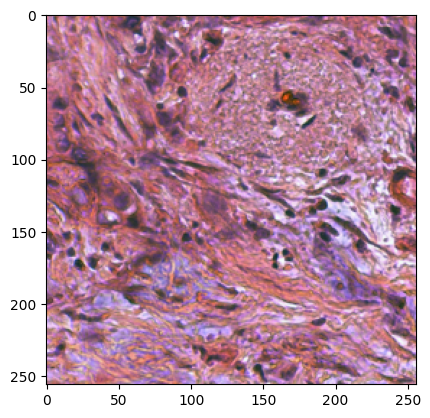

In [33]:
img = rearrange(ds[i]['he'], 'c h w -> h w c')
img -= img.min()
img /= img.max()
plt.imshow(img)

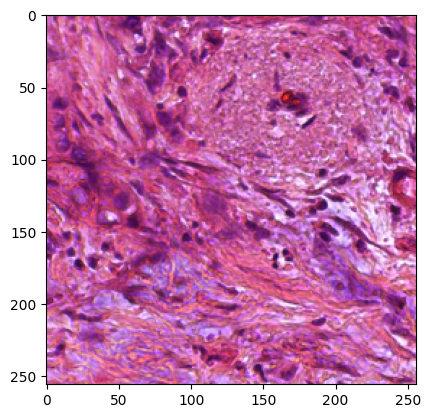

In [34]:
img = rearrange(ds[i]['he_orig'], 'c h w -> h w c')
plt.imshow(img)

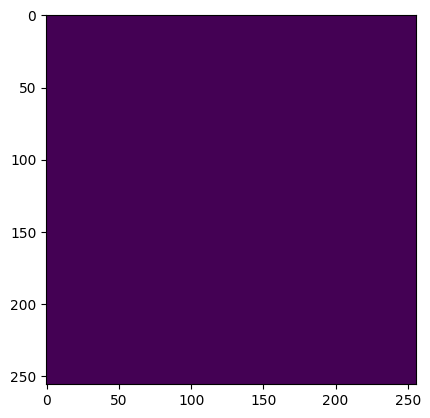

In [35]:
plt.imshow(torch.sum(ds[i]['masks'], dim=0))

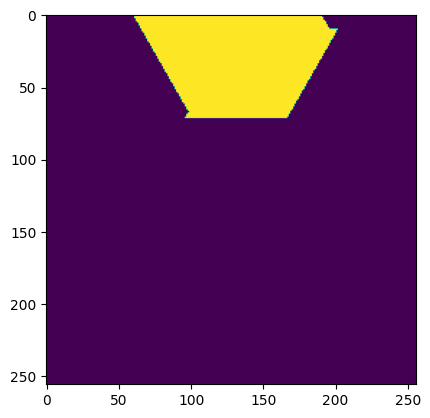

In [36]:
plt.imshow(ds[i]['masks'][6])

In [41]:
ds[i]['voxel_idxs']

tensor([1262, 1852, 2357, 2566, 2627, 2759, 3166, 3340, 3855,    0,    0,    0,
           0,    0,    0,    0], dtype=torch.int16)

In [49]:
ds[i]['exp']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [85]:
a = sc.read_h5ad('../data/pytorch_datasets/pdac_v1/train/adata.h5ad')
a

AnnData object with n_obs × n_vars = 3940 × 2001
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'